# Setup imports and loader

In [1]:
import matplotlib.pyplot as plt
import incense
from common.helper.config import parseMongoConfig

loader = incense.ExperimentLoader(**parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))

/home/jroeger/data/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Find failed Experiments, due to misconfiguration
The problem was, that pytorch does not support PerChannel activation quantization.

In [2]:
from collections import defaultdict


failed_query = {
    '$and': [
        {
            'experiment.name': 'PTSQ_CNN-IMU_LARa'
        },
        {
            'status': 'FAILED'
        },
        {
            '_id': {'$gte': 240}
        },
    ]
}
failed_experiments = loader.find(failed_query)

print(f'Found {len(failed_experiments)} failed Experiments')

exs_by_relevant_config_tuples = defaultdict(list)
for ex in failed_experiments:
  cfg = ex.to_dict()['config']
  exs_by_relevant_config_tuples[(cfg['activation_observer'], cfg['weight_observer'])].append(ex)

for (activation, weight), exs in exs_by_relevant_config_tuples.items():
  print(f'- activation = {activation}')
  print(f'  weight     = {weight}')
  for trace in set([ex.to_dict()["fail_trace"][-1] for ex in exs]):
    print(f'    {trace}',end='')

Found 180 failed Experiments
- activation = torch.ao.quantization.PerChannelMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.PerChannelMinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.MovingAveragePerChannelMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.MovingAvera

## Confirm by checking all `COMPLETED` experiments
Exactly all PerTensor activation observers succeeded

In [3]:
completed_query = {
    '$and': [
        {
            'experiment.name': 'PTSQ_CNN-IMU_LARa'
        },
        {
            'status': 'COMPLETED'
        },
        {
            '_id': {
                '$gte': 241
            }
        },
    ]
}
completed_experiments = loader.find(completed_query)
print(f'There are {len(completed_experiments)} completed experiments')
observer_cfgs = [(e.to_dict()['config']['activation_observer'],
                  e.to_dict()['config']['weight_observer']) for e in completed_experiments]

print('Distinct observer combinations:')
for act, wgt in set(observer_cfgs):
  print(f'- activation = {act}')
  print(f'  weight     = {wgt}')


There are 270 completed experiments
Distinct observer combinations:
- activation = torch.ao.quantization.HistogramObserver
  weight     = torch.ao.quantization.MinMaxObserver
- activation = torch.ao.quantization.HistogramObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.MovingAverageMinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.MinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
- activation = torch.ao.quantization.MinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.MovingAverageMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver


# Best Quantization Results

In [4]:
best_wf1 = max(completed_experiments, key=lambda e: e.metrics['test/wf1'].max())

print(f'Best WF1 Scrore has Experiment {best_wf1.id}')
print(f'  Accuracy: {best_wf1.metrics["test/acc"].item()}')
print(f'  WF1:      {best_wf1.metrics["test/wf1"].item()}')
print(f'  Loss:     {best_wf1.metrics["test/loss"].mean()}')
print(f'Config: {best_wf1.to_dict()["config"]}')

Best WF1 Scrore has Experiment 296
  Accuracy: 0.7567296624183655
  WF1:      0.7431341409683228
  Loss:     0.6652039885520935
Config: {'weight_observer': 'torch.ao.quantization.MinMaxObserver', 'seed': 83224074, 'weight_observer_args': {'quant_min': -64, 'quant_max': 63, 'qscheme': {'_global_name': 'torch.per_tensor_affine', 'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_kwargs': {}}, 'dtype': {'_global_name': 'torch.qint8', 'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_kwargs': {}}}, 'activation_qscheme': 'torch.per_tensor_affine', 'weight_range': 'full', 'activation_observer_args': {'quant_min': 0, 'quant_max': 127, 'qscheme': {'_global_name': 'torch.per_tensor_affine', 'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_kwargs': {}}, 'dtype': {'_global_name': 'torch.quint8', 'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_kwargs': {}}}, 'trained_model_run_id': 225, 'batch_size': 32, 'weight_qscheme': 'torch.per

# Best Quantization Results per Quantization Bitwidth

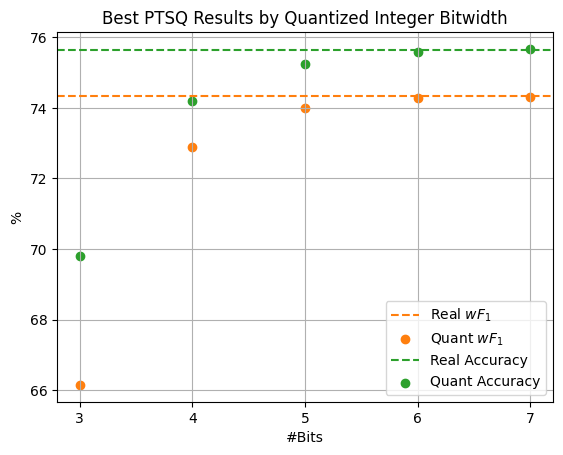

In [5]:
import matplotlib.pyplot as plt

experiments_by_bits = defaultdict(list)
for e in completed_experiments:
  experiments_by_bits[e.to_dict()['config']['n_bits']].append(e)

best_wf1_by_bits = {
    bits: max(exs, key=lambda e: e.metrics['test/wf1'].item())
    for bits, exs in experiments_by_bits.items()
}
base_experiments = loader.find_by_ids([e.to_dict()['config']['trained_model_run_id'] for e in best_wf1_by_bits.values()])
assert len(set(base_experiments)) == 1
base_experiment = base_experiments[0]

cmap=plt.colormaps.get('tab10')
fig, ax = plt.subplots()
ax.axhline(y=base_experiment.metrics['test/wf1'].max()*100, color=cmap(1), label='Real $wF_1$', linestyle='dashed')
ax.scatter(x=list(best_wf1_by_bits.keys()), y=[e.metrics['test/wf1'].item()*100 for e in best_wf1_by_bits.values()], color=cmap(1), label='Quant $wF_1$')
ax.axhline(y=base_experiment.metrics['test/acc'].max()*100, color=cmap(2), label='Real Accuracy', linestyle='dashed')
ax.scatter(x=list(best_wf1_by_bits.keys()), y=[e.metrics['test/acc'].item()*100 for e in best_wf1_by_bits.values()], color=cmap(2), label='Quant Accuracy')
ax.grid(True)
ax.set_xticks(list(best_wf1_by_bits.keys()))
ax.set_xlabel('#Bits')
ax.set_ylabel('%')
ax.set_title('Best PTSQ Results by Quantized Integer Bitwidth')
ax.legend()
fig.show()